<a href="https://colab.research.google.com/github/PlayMoodify/PlayMoodify.app/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PlayMoodify


Analisi del dataset ottenuto tramite la piattaforma Kaggle

In [48]:
# Caricamento del dataset dalla piattaforma kaggle
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split


file_path = "278k_song_labelled.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "abdullahorzan/moodify-dataset",
  file_path,
)


Using Colab cache for faster access to the 'moodify-dataset' dataset.


In [49]:
# Visualizzazione della struttura dataset, con visualizzazione dei primi 5 record di quest'ultimo

In [50]:
display(df.head())

,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1


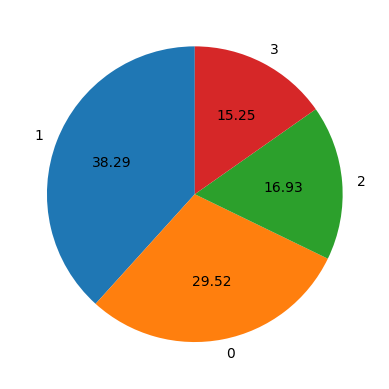

In [51]:
# Distribuzione delle classi {'sad' : 0, 'happy' : 1, 'Energetic' : 2, 'Calm' : 3}
plt.pie(df["labels"].value_counts().values, labels=df["labels"].value_counts().index, autopct="%.2f", startangle=90)
plt.show()

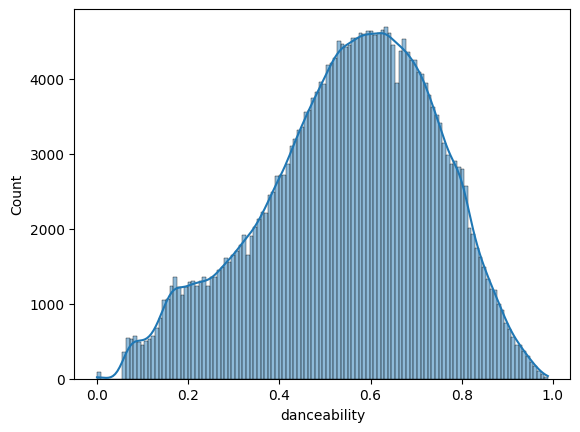

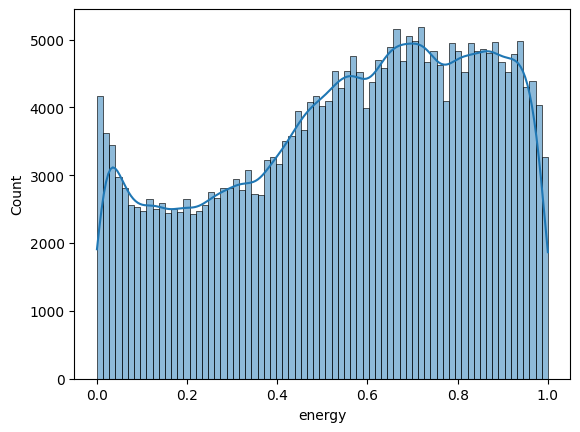

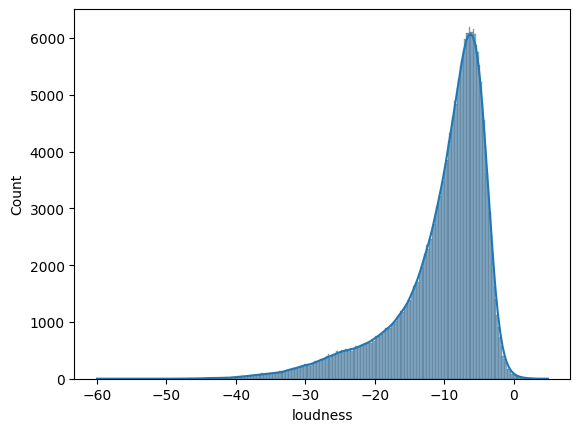

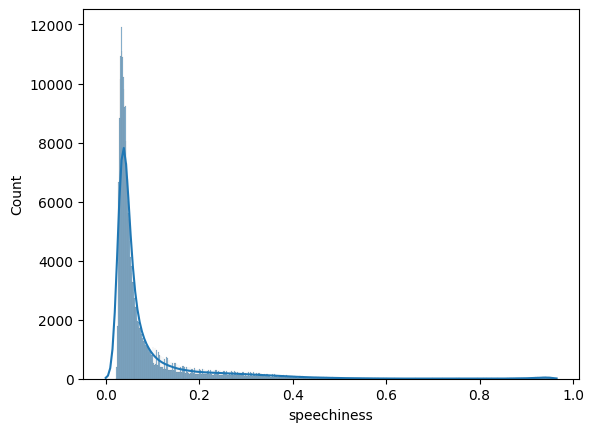

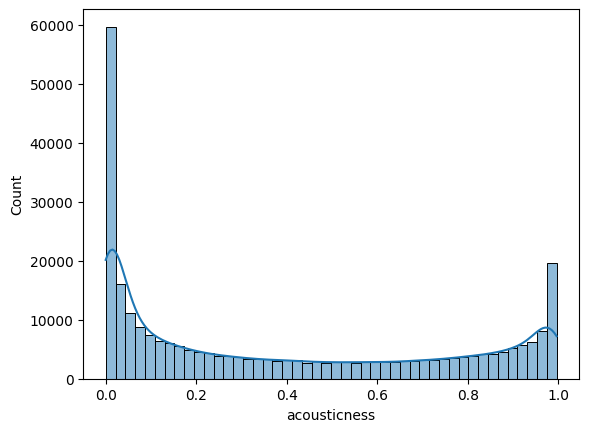

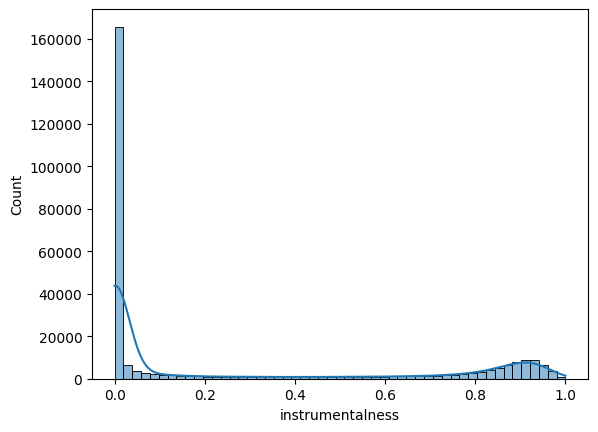

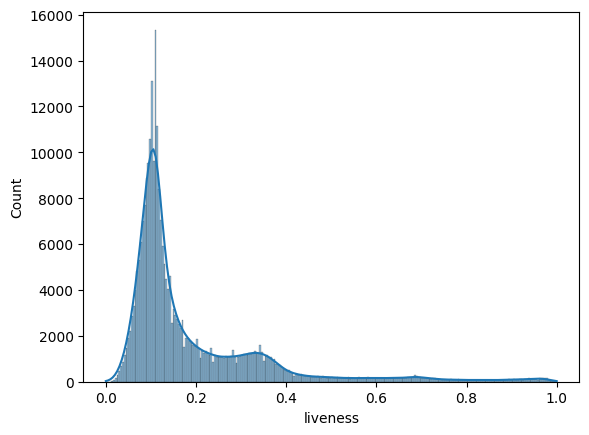

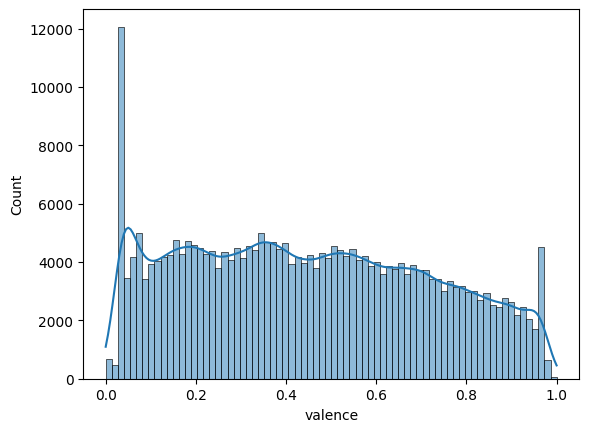

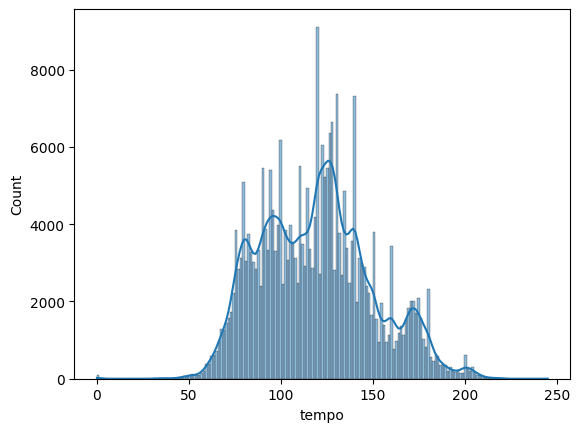

In [52]:
# Analisi della distribuzione delle singole feature all'interno del dataset
sns.histplot(df["danceability"], kde=True)
plt.show()

sns.histplot(df["energy"], kde=True)
plt.show()

sns.histplot(df["loudness"], kde=True)
plt.show()

sns.histplot(df["speechiness"], kde=True)
plt.show()

sns.histplot(df["acousticness"], kde=True)
plt.show()

sns.histplot(df["instrumentalness"], kde=True)
plt.show()

sns.histplot(df["liveness"], kde=True)
plt.show()

sns.histplot(df["valence"], kde=True)
plt.show()

sns.histplot(df["tempo"], kde=True)
plt.show()

Dall’osservazione dei grafici sopra riportati possiamo notare che:
*   La feature Energy risulta essere ben distribuita nella scala tra 0 e 1;
*   Le feature Speechiness e Instrumentalness hanno un alto picco su 0;
*   Le feature Acousticness e Valence hanno picchi sia su 0 che su 1;
*   La feature Danceability ha un picco nei valori che vanno tra 0.4 e 0.8;
*   La feature Liveness ha un picco tra 0 e 0.2, per poi decrescere
drasticamente fino ad 1.







Individuazione di entry non significative

In [53]:
# Verifichiamo la presenza di brani campionati in modo errato
print((df["spec_rate"] == 0.0).sum())
display(df[df["spec_rate"] == 0.0])

90


,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
4854,4854,161474.0,0.0,0.93200,-13.238,0.0,0.123000,1.000000,0.7200,0.0,0.0,0.0,0
11951,11951,14040.0,0.0,0.81700,-10.403,0.0,0.650000,0.013600,0.1010,0.0,0.0,0.0,0
13183,13183,189000.0,0.0,0.96800,-5.182,0.0,0.000004,0.000036,0.1160,0.0,0.0,0.0,2
23301,23301,223280.0,0.0,0.16900,-14.467,0.0,0.598000,0.274000,0.2990,0.0,0.0,0.0,0
24380,24380,147000.0,0.0,0.40500,-9.935,0.0,0.842000,0.001140,0.1980,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
269701,269701,11227.0,0.0,0.03040,-17.836,0.0,0.000238,0.596000,0.0694,0.0,0.0,0.0,3
269815,269815,39493.0,0.0,0.00002,-60.000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0
271602,271602,168720.0,0.0,0.36400,-8.046,0.0,0.671000,0.000000,0.1780,0.0,0.0,0.0,0
272146,272146,188400.0,0.0,0.06440,-18.222,0.0,0.982000,0.598000,0.2680,0.0,0.0,0.0,3


In [54]:
# Verifichiamo la presenza di tracce che hanno tempo (bpm) pari a 0.0, che rappresentano errori di campionamento o tracce che non sono canzoni
print((df["tempo"] == 0.0).sum())
display(df[df["tempo"] == 0.0])

90


,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
4854,4854,161474.0,0.0,0.93200,-13.238,0.0,0.123000,1.000000,0.7200,0.0,0.0,0.0,0
11951,11951,14040.0,0.0,0.81700,-10.403,0.0,0.650000,0.013600,0.1010,0.0,0.0,0.0,0
13183,13183,189000.0,0.0,0.96800,-5.182,0.0,0.000004,0.000036,0.1160,0.0,0.0,0.0,2
23301,23301,223280.0,0.0,0.16900,-14.467,0.0,0.598000,0.274000,0.2990,0.0,0.0,0.0,0
24380,24380,147000.0,0.0,0.40500,-9.935,0.0,0.842000,0.001140,0.1980,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
269701,269701,11227.0,0.0,0.03040,-17.836,0.0,0.000238,0.596000,0.0694,0.0,0.0,0.0,3
269815,269815,39493.0,0.0,0.00002,-60.000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0
271602,271602,168720.0,0.0,0.36400,-8.046,0.0,0.671000,0.000000,0.1780,0.0,0.0,0.0,0
272146,272146,188400.0,0.0,0.06440,-18.222,0.0,0.982000,0.598000,0.2680,0.0,0.0,0.0,3


In [55]:
# Verifichiamo la presenza di entry che non rappresentano brani, poichè di durata troppo breve o troppo elevata. Dunque, podcast, ecc...
df["duration (min)"] = df["duration (ms)"] / (1000 * 60)
df.drop("duration (ms)", axis=1, inplace=True)

# Tracce di lunghezza superiore a 10 min
print("TRACCE MAGGIORI DI 10 MINUTI: ")
print((df["duration (min)"] > 10).sum())
display(df[df["duration (min)"] > 10])

# Tracce con lunghezza inferiore ad 1 min
print("TRACCE INFERIORI A 1 MINUTO: ")
print((df["duration (min)"] < 1).sum())
display(df[df["duration (min)"] < 1])

TRACCE MAGGIORI DI 10 MINUTI: 
2949


,Unnamed: 0,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels,duration (min)
301,301,0.457,0.9650,0.457,0.4860,0.085,0.000000,0.6970,0.6040,170.122,7.682276e-07,2,10.543750
627,627,0.528,0.3490,-18.761,0.0302,0.474,0.497000,0.6280,0.6420,76.097,4.231013e-08,0,11.896283
650,650,0.412,0.4600,-13.222,0.0336,0.118,0.411000,0.7190,0.6040,102.135,4.008795e-08,0,13.969283
651,651,0.590,0.3900,-15.613,0.0335,0.248,0.403000,0.9880,0.5630,104.619,4.761952e-08,0,11.724883
751,751,0.559,0.5110,-11.167,0.0326,0.553,0.802000,0.0865,0.7420,87.999,4.402312e-08,0,12.342000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275314,275314,0.227,0.1750,-16.656,0.0392,0.906,0.000005,0.0993,0.2130,76.105,5.764138e-08,0,11.334450
275331,275331,0.175,0.3460,-9.170,0.0340,0.661,0.000002,0.6300,0.1520,179.026,5.657389e-08,0,10.016400
275332,275332,0.318,0.2150,-13.555,0.0341,0.868,0.000000,0.2380,0.1960,101.310,3.965116e-08,0,14.333333
275339,275339,0.251,0.3380,-9.224,0.0295,0.838,0.000000,0.1000,0.2080,146.687,4.092510e-08,0,12.013817


TRACCE INFERIORI A 1 MINUTO: 
1680


,Unnamed: 0,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels,duration (min)
1061,1061,0.417,0.1400,-14.404,0.0495,0.712,0.224000,0.1910,0.03940,47.689,1.530234e-06,0,0.539133
1402,1402,0.686,0.4370,-10.040,0.0984,0.601,0.000028,0.1530,0.57900,71.652,1.845012e-06,1,0.888883
1404,1404,0.683,0.4680,-10.058,0.0743,0.870,0.673000,0.1080,0.47000,117.095,1.292264e-06,0,0.958267
1704,1704,0.531,0.4980,-20.324,0.1230,0.385,0.892000,0.3030,0.26100,100.182,2.214341e-06,3,0.925783
1882,1882,0.851,0.3660,-9.884,0.0429,0.918,0.459000,0.3100,0.91100,74.385,8.081379e-07,0,0.884750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276881,276881,0.491,0.2330,-13.970,0.2230,0.898,0.833000,0.1080,0.15800,209.887,3.859400e-06,3,0.963017
276886,276886,0.119,0.7340,-18.570,0.0677,0.505,0.895000,0.1690,0.00001,97.174,1.259371e-06,3,0.895950
277800,277800,0.688,0.5730,-14.046,0.3580,0.778,0.000366,0.3480,0.94800,98.871,6.572787e-06,1,0.907783
277845,277845,0.824,0.0773,-12.007,0.2720,0.918,0.000687,0.0963,0.39300,137.227,6.100159e-06,0,0.743150


Rimozione di entry e feature non significative

In [56]:
# Rimuoviamo le entry non significative
print(f"Dimensione record prima della rimozione delle entry non significative: {df.shape[0]}")
df.drop(df[df["spec_rate"] == 0.0].index, inplace=True)
df.drop(df[df["tempo"] == 0.0].index, inplace=True)
df.drop(df[df["duration (min)"] > 10].index, inplace=True)
df.drop(df[df["duration (min)"] < 1].index, inplace=True)
print(f"Dimensione record dopo la rimozione delle entry non significative: {df.shape[0]}")

Dimensione record prima della rimozione delle entry non significative: 277938
Dimensione record dopo la rimozione delle entry non significative: 273252


In [57]:
# Rimuoviamo le feature non significative
df.drop("duration (min)", axis=1, inplace=True)
df.drop("spec_rate", axis=1, inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)
display(df.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,labels
0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,2
1,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1
2,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,1
3,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,0
4,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,1


Analizziamo nuovamente la distribuzione delle classi e delle feature nel dataset dopo la pulizia da feature e entry non significative

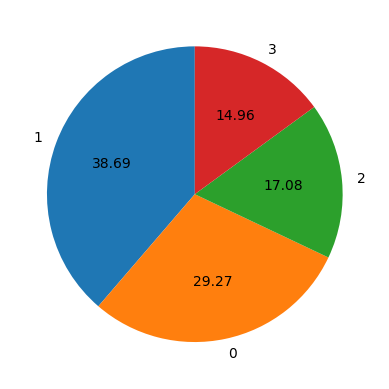

In [58]:
# Distribuzione delle classi dopo la pulizia del dataset
plt.pie(df["labels"].value_counts().values, labels=df["labels"].value_counts().index, autopct="%.2f", startangle=90)
plt.show()

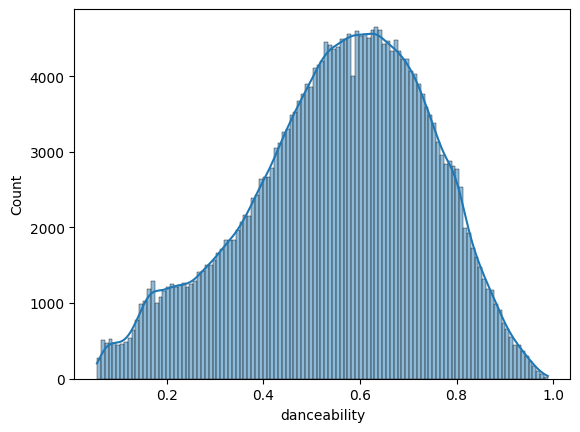

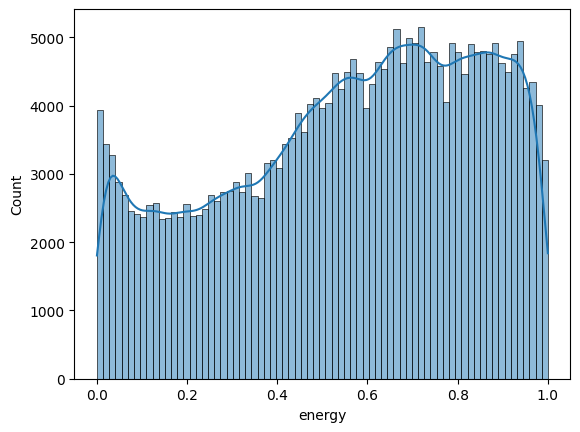

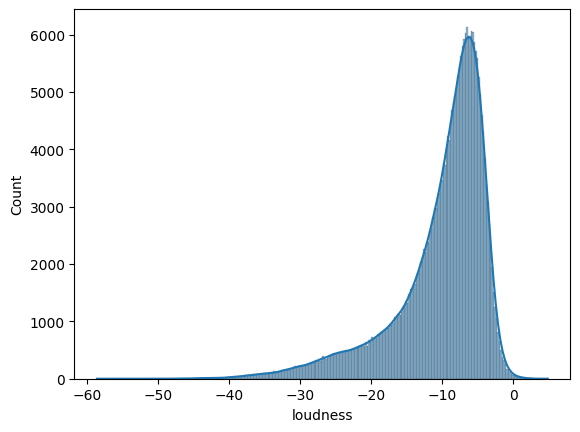

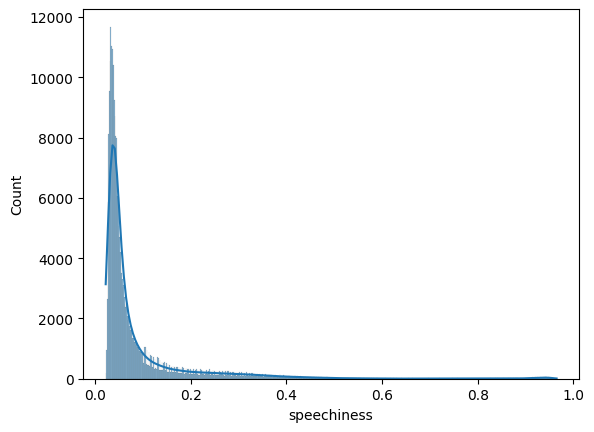

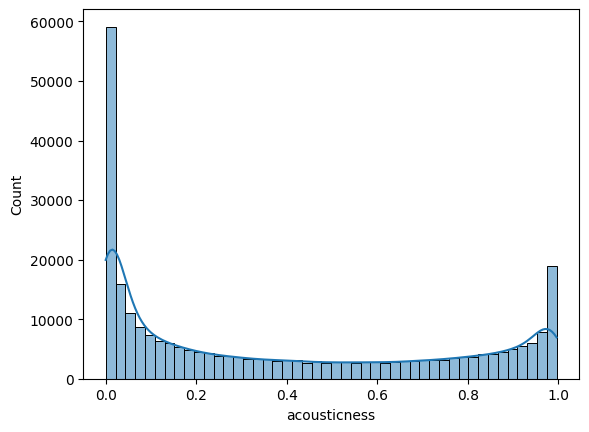

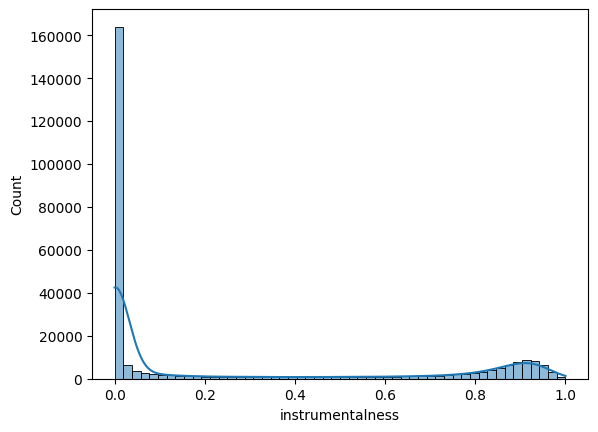

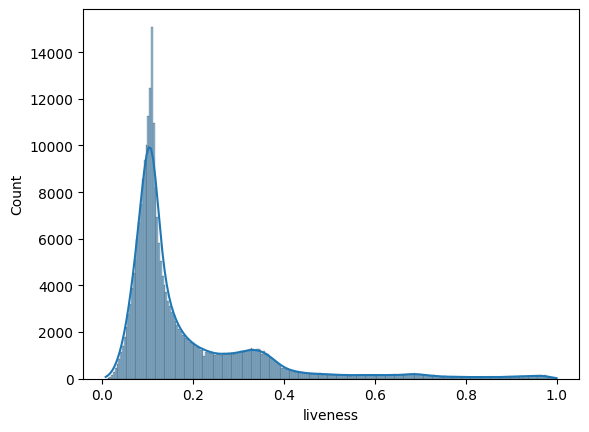

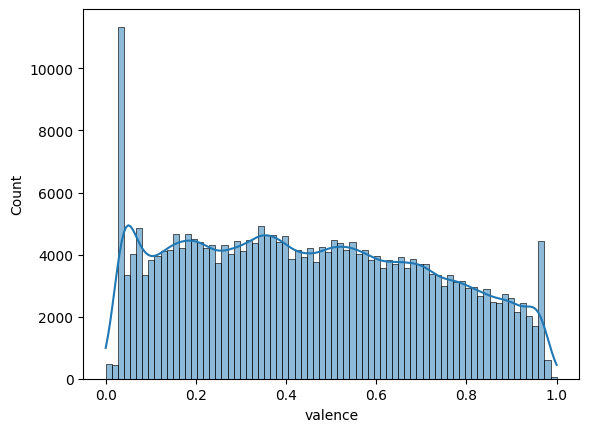

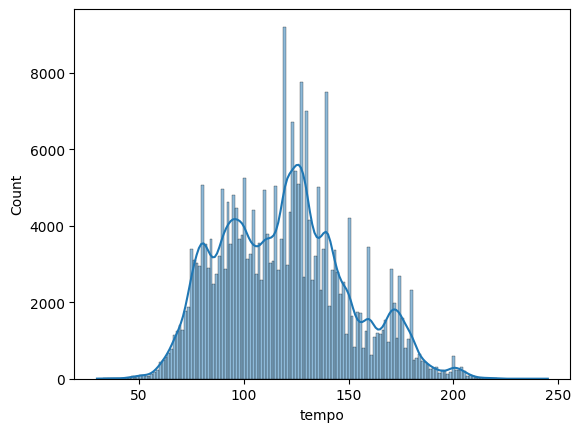

In [59]:
# Analisi della distribuzione delle singole feature dopo la pulizia del dataset
sns.histplot(df["danceability"], kde=True)
plt.show()

sns.histplot(df["energy"], kde=True)
plt.show()

sns.histplot(df["loudness"], kde=True)
plt.show()

sns.histplot(df["speechiness"], kde=True)
plt.show()

sns.histplot(df["acousticness"], kde=True)
plt.show()

sns.histplot(df["instrumentalness"], kde=True)
plt.show()

sns.histplot(df["liveness"], kde=True)
plt.show()

sns.histplot(df["valence"], kde=True)
plt.show()

sns.histplot(df["tempo"], kde=True)
plt.show()